imports

In [8]:
import os
#only print error messages from tensorflow
import tensorflow as tf
import numpy as np
import math
import time
import pickle
import bz2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,MaxAbsScaler
import copy
from sklearn.metrics import mean_squared_error,mean_absolute_error
import scipy.optimize as opt
from itertools import chain

In [9]:
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

In [70]:
def analytical_eq(xy,xo,yo,No,T):   
    x, y = xy
    
    Nex = 100000-No
    
    # out = (No/math.pi)*np.exp(-(x-xo)**2)*np.exp(-(y-yo)**2) + (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))
    out = (Nex/(2*math.pi*T))*np.exp((-(x-xo)**2)/(2*T))*np.exp((-(y-yo)**2)/(2*T))

    # out = (out - np.min(out)) / np.max(out)
    return out

In [130]:
num_atoms = 100000
length = 100
dimensions = 2
        
        
def generate_image(length,num_atoms,dimensions,temp):
    '''
    generate image using sampling
    '''

    x_list = []
    y_list = []
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    # trans_temp = 174
    # temp = np.random.uniform(trans_temp//2,int(trans_temp*2))
    # temp = 300
    
    temp_ratio = temp/trans_temp

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    count = 0
    
    for i in range(num_atoms):
        probability = np.random.rand()
        if temp_ratio >1 :
            temp_ratio = 1
        BEC_probability = (1-(temp_ratio)**dimensions)
        if probability <= BEC_probability:
            count += 1
            x_list.append(np.random.normal(0,math.sqrt(1/2)))
            y_list.append(np.random.normal(0,math.sqrt(1/2)))

        else:
            x_list.append(np.random.normal(0,math.sqrt(temp)))
            y_list.append(np.random.normal(0,math.sqrt(temp)))



    hist = np.histogram2d(x_list,y_list,length)[0]
    hist = hist.tolist()
    return hist,temp,num_BEC_atoms,count

test_im_count = 10
test_ims = []
labs = []
temp = 150
for i in range(test_im_count):
    curr_im, t, n, count = generate_image(length,num_atoms,dimensions,temp)
    
    test_ims.append(np.asarray(curr_im))
    labs.append((t,n,count))

test_ims = np.stack(test_ims)
labs = np.stack(labs)

In [131]:
test_ims.shape

(10, 100, 100)

In [132]:
stdev_test_ims = np.std(test_ims,axis = 0)

In [133]:
std_err = stdev_test_ims / np.sqrt(test_ims.shape[0])

In [134]:
# std_err = (std_err - np.min(std_err)) / np.max(std_err)

In [135]:
mean_test_im = np.mean(test_ims,axis = 0)

In [136]:
# mean_test_im = (mean_test_im - np.min(mean_test_im)) / np.max(mean_test_im)

In [137]:
summ_all_mean = np.sum(mean_test_im)
summ_all_mean

100000.0

In [138]:
pxy = mean_test_im/summ_all_mean
px = np.sum(pxy,axis = 1)
res = px * np.linspace(-49, 50, 100)
expected_val_x = np.sum(res)
expected_val_x2 = np.sum(px * np.linspace(-49, 50, 100) ** 2)

In [139]:
np.sum(px)

1.0

In [140]:
expected_val_x

-0.5465019999999999

In [141]:
expected_val_x2

98.817826

In [142]:
var_sampling = expected_val_x2 - expected_val_x**2

In [143]:
x = np.linspace(-49, 50, 100)
y = np.linspace(-49, 50, 100)
x, y = np.meshgrid(x, y)

num_atoms = 100000
dimensions = 2
# temp = 300

trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
# num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
num_BEC_atoms = 0

actual = analytical_eq((x,y),0,0,num_BEC_atoms,temp)

In [144]:
summ_actual = np.sum(actual)
summ_actual

99991.0019198216

In [145]:
pxy_actual = actual/summ_actual
px_actual = np.sum(pxy_actual,axis = 1)
res = px_actual * np.linspace(-49, 50, 100)
expected_val_x_actual = np.sum(res)
expected_val_x2_actual = np.sum(px_actual * np.linspace(-49, 50, 100) ** 2)

In [146]:
expected_val_x_actual

0.00039150138074510655

In [147]:
expected_val_x2_actual

149.88165874643158

In [148]:
var_actual = expected_val_x2_actual - expected_val_x_actual**2
var_actual

149.88165859315825

In [149]:
# length = 100
# actual = np.reshape(actual,(length,length))
# actual.shape

In [150]:
print(var_sampling,var_actual)

98.519161563996 149.88165859315825


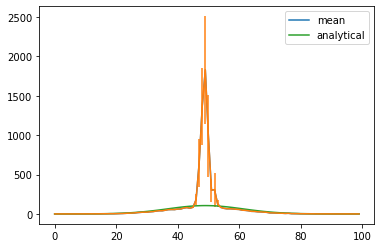

In [113]:
#mean gaussian

row = 50

plt.plot(np.arange(len(mean_test_im[0])),mean_test_im[row],label = "mean")
plt.errorbar(np.arange(len(mean_test_im[0])),mean_test_im[row],yerr = std_err[row])
plt.plot(np.arange(len(mean_test_im[0])),actual[row],label = "analytical")
plt.legend()

In [114]:
num_atoms = 100000
temp_ratio = (num_atoms/(2*1*1.645))**0.5
length = 100
dimensions = 2

x = np.linspace(-length//2+1, length//2, length)
y = np.linspace(-length//2+1, length//2, length)
x, y = np.meshgrid(x, y)

        
        
def generate_image_without_sampling(temp_ratio,length,num_atoms,dimensions,x,y):

    res = np.zeros((length,length))
    
    trans_temp = (num_atoms/(2*1*1.645))**(1/dimensions)
    
    temp = np.random.uniform(trans_temp//2,int(trans_temp*2))

    num_BEC_atoms = 0
    if temp < trans_temp:
        num_BEC_atoms = num_atoms*(1-(temp/trans_temp)**dimensions)
        
    for i in range(length):
        for j in range(length):

            res[i,j] = (num_BEC_atoms/math.pi)*np.exp(-(x[i,j])**2)*np.exp(-(y[i,j])**2) + ((100000-num_BEC_atoms)/(2*math.pi*temp))*np.exp((-(x[i,j])**2)/(2*temp))*np.exp((-(y[i,j])**2)/(2*temp)) + np.random.normal()

    return res,temp,num_BEC_atoms

noisy_ims = []
noisy_labs = []

test_im_count = 1
for i in range(test_im_count):
    curr_im, t, n = generate_image_without_sampling(temp_ratio,length,num_atoms,dimensions,x,y)
    
    noisy_ims.append(np.asarray(curr_im))
    noisy_labs.append((t,n))

noisy_ims = np.stack(noisy_ims)
noisy_labs = np.stack(noisy_labs)

In [115]:
normalized_noisy_ims = []
for im in noisy_ims:
    normalized_noisy_ims.append((im - np.min(im))/np.max(im))
normalized_noisy_ims = np.stack(normalized_noisy_ims)

In [116]:
initial_guess = (0,0,50000,175)
noisy_preds = []
noisy_origins = []
for i,im in enumerate(normalized_noisy_ims):
    popt, _ = opt.curve_fit(analytical_eq, (x, y), im.ravel(), p0=initial_guess)
    xo,yo = popt[:2]
    pred_No = popt[2]
    pred_T = popt[3]
    if pred_No < 0:
        pred_No = 0
    if pred_T < 0:
        pred_T = 0
    noisy_preds.append((pred_T,pred_No))
    noisy_origins.append((xo,yo))
        
noisy_preds = np.asarray(noisy_preds)

ValueError: operands could not be broadcast together with shapes (100,100) (10000,) 

In [ ]:
check_indx = 0

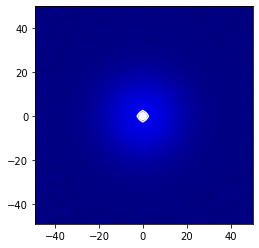

In [393]:
data_fitted = analytical_eq((x, y), *noisy_origins[check_indx],*noisy_preds[check_indx][::-1])

fig, ax = plt.subplots(1, 1)
ax.imshow(normalized_noisy_ims[0].reshape(100, 100), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(100, 100),10, colors='w')
plt.show()

In [394]:
noisy_analytical_solns = []
for t,n in noisy_labs:
    noisy_analytical_solns.append(analytical_eq((x,y),0,0,n,t))
noisy_analytical_solns = np.array(noisy_analytical_solns)

In [395]:
length = 100
noisy_analytical_solns = np.reshape(noisy_analytical_solns,(test_im_count,length,length))

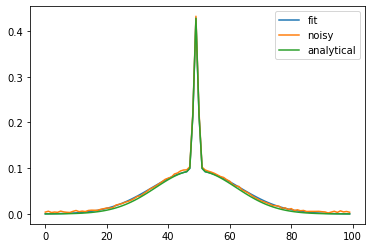

In [397]:
#fit gaussian vs noisy gaussian

row = 50

check = data_fitted.reshape(100,100)
plt.plot(np.arange(len(check[0])),check[row],label = "fit")
plt.plot(np.arange(len(check[0])),normalized_noisy_ims[check_indx,row],label = "noisy")
plt.plot(np.arange(len(check[0])),noisy_analytical_solns[check_indx,row],label = "analytical")
plt.legend()

In [232]:
noisy_labs[check_indx]

array([  139.43210503, 36038.08380333])

In [233]:
noisy_preds[check_indx]

array([  178.59729931, 30877.22892256])

In [234]:
noisy_fit_T_rmse = mean_squared_error(noisy_preds[:,0],noisy_labs[:,0],squared = False)

In [235]:
noisy_fit_T_rmse

56.99156515921587

In [236]:
noisy_fit_N_rmse = mean_squared_error(noisy_preds[:,1],noisy_labs[:,1],squared = False)

In [237]:
noisy_fit_N_rmse

3361.3204227242472